# ssDNA-Hi-C Analysis Pipeline Tutorial

This notebook runs the complete sshicstuff sample pipeline on one Graal sparse matrix, from input sanity checks to aggregated 4C-like summaries around centromeres and telomeres.
It is a thin, reproducible wrapper around the library entry-points in core/, so every cell maps directly to a function or a CLI command exposed in commands.py.


In [1]:
import os
os.environ['NUMEXPR_MAX_THREADS'] = '4'
os.environ.pop("MPLBACKEND", None)
import pandas as pd

from os.path import join

## 1. Full Pipeline inputs overview

Each run of the pipeline requires the following input files:

Each run of the pipeline requires several input files:

- **`-m / --sparse-matrix`** — Sparse contact matrix produced by *hicstuff* (usually the `graal.tsv` file).  
  Contains pairwise fragment contacts (frag_a, frag_b, contacts).
- **`-c / --oligo-capture`** — CSV/TSV file describing the designed capture oligos (probes).  
  Each probe includes chromosome, start, end, and sequence coordinates. See **design tutorial** to see how to built it. 
- **`-f / --fragments`** — Fragment list generated during genome digestion by *hicstuff*.  
  Provides genomic coordinates of each restriction fragment.
- **`-C / --chr-coord`** — Chromosome coordinate file containing chromosome names, lengths, and centromere/telomere positions.  
  Used for rebinning and aggregation steps.
- **`-a / --additional-groups`** *(optional)* — Probe grouping file allowing the definition of custom probe sets or regions for aggregation.

---

And the following optionnal arguments

- **-b / --binning-sizes** — List of binning sizes for rebinning (e.g. 1000, 10000 bp)
- **-E / --exclude** — Chromosomes to exclude from the analysis
- **-F / --force** — Overwrite existing files
- **-I / --inter** — Keep only inter-chromosomal contacts
- **-n / --flanking-number** — Number of flanking fragments to remove around ssDNA probes (default: 2)
- **-N / --normalize** — Normalize contact frequencies
- **-o / --output** — Output directory
- **-r / --cis-range** — Cis interaction distance in bp (default: 50,000)
- **--binning-aggregate-cen** — Bin size used for centromere aggregation (default: 10 kb)
- **--binning-aggregate-telo** — Bin size used for telomere aggregation (default: 1 kb)
- **--window-size-cen** — Centromere aggregation window (default: 150 kb)
- **--window-size-telo** — Telomere aggregation window (default: 15 kb)
- **--copy-inputs** — Copy all input files to the output directory for reproducibility


In [2]:
### Common inouts path / filenames
INPUTS_DIR = "../test_data/inputs"
OUTPUTS_DIR = "../test_data/outputs"

graal = "Graal_sample_for_pipeline.txt"
capture = "capture_oligo_for_pipeline.csv"
coords = "chr_coordinates_for_pipeline.tsv"
frags = "fragments_list_for_pipeline.txt"
groups = "probe_groups_for_pipeline.tsv"


## Overview of the pipeline

The notebook calls `pipeline.full_pipeline(...)` which orchestrates the following sequence and writes all artefacts into a run directory named after the sparse matrix.

1. Associate probes to fragments
2. Split reads into dsDNA-only and ssDNA-only matrices
3. Filter contacts to pairs with at least one probe
4. Generate probe-only square profiles
5. Compute 4C-like profiles at 0 kb
6. Rebin profiles to additional resolutions
7. Compute per-probe statistics
8. Aggregate signals near centromeres and telomeres

Each step corresponds to a callable in `core/` and a subcommand in `commands.py`.


In [3]:
### Full Pipeline
# Uncomment to run
# ARGS = [
#     "-m", join(INPUTS_DIR, graal),
#     "-c", join(INPUTS_DIR, capture),
#     "-C", join(INPUTS_DIR, coords),
#     "-f", join(INPUTS_DIR, frags),
#     "-a", join(INPUTS_DIR, groups),
#     "-n", "2",
#     "-I",
#     "-N",
#     "-o", OUTPUTS_DIR,
#     "-b", "1000",
#     "-b", "2000",
#     "-b", "5000",
#     "-b", "10000",
#     "-r", "50000",
#     "--binning-aggregate-cen", "10000",
#     "--binning-aggregate-telo", "1000",
#     "--window-size-cen", "150000",
#     "--window-size-telo", "15000",
#     "--copy-inputs",
#     "-F",
# ]
#
# cmd = "sshicstuff pipeline " + " ".join(ARGS)
# !{cmd}

## Step-by-step description

### 1. Associate probes to fragments

**What happens:**
Each probe midpoint is matched to its closest fragment (read number) on the same chromosome from the `hicstuff` digest. The probe table gains three new columns: `fragment`, `fragment_start`, and `fragment_end`.

**Output:**
`<oligo_capture>_fragments_associated.csv`

**Notes:**
Input file types are verified, overwrite behavior is controlled by `force`.

In [4]:
## Associate
capture_associated_path = join(OUTPUTS_DIR, "inputs/capture_oligo_for_pipeline_fragments_associated.csv")

ARGS = [
    "associate",
    "-c",  join(INPUTS_DIR, capture),
    "-f",  join(INPUTS_DIR, frags),
    "-o",  capture_associated_path,
    "-F",
]
cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}
df_associated = pd.read_table(capture_associated_path, sep=",")
df_associated.loc[:, ["name", "fragment", "fragment_start", "fragment_end"]].head()

INFO :: [Associate] : Associate oligo/probe name to fragment/read ID that contains it.
INFO :: [Associate] : Creating a new oligo_capture table : capture_oligo_for_pipeline_fragments_associated.csv
INFO :: [Associate] : oligos associated to fragments successfully.


,name,fragment,fragment_start,fragment_end
0,Native_URA-L-17213-MfeI-RC,74823,0,289
1,Native_URA-L-16220-MfeI-RC,74824,289,655
2,Native_URA-L-15683-SspI-RC,74825,655,1021
3,Native_URA-L-9924-MfeI-RC,74826,1021,1387
4,Native_URA-L-6532-MfeI-RC,74827,1387,1727



### 2. dsDNA-only and ssDNA-only matrices, plus coverage

**What happens:**  
Two sparse matrices are created by selecting contacts involving dsDNA or ssDNA probes from the original sparse one (Graal matrix).\

Optional argument `n_flanking_dsdna` removes neighbors around dsDNA probes.  
Coverage is computed by melting counts per fragment, and fragments crossing bin edges are proportionally split when `bin_size > 0`.
Coverage can be done either on original sparse matrix, or dsDNA or 

**Outputs:**  
`*_dsdna_only.txt`, `*_ssdna_only.txt`, `*_contacts_coverage.bedgraph`, and, if binned, `*_contacts_coverage_<bin>.bedgraph`

**Options:**  
`normalize=True` applies column-sum normalization to coverage values.


In [5]:
## dsdnaonly
ARGS = [
    "dsdnaonly",
    "-m", join(INPUTS_DIR, graal),
    "-c", capture_associated_path,
    "-o", join(OUTPUTS_DIR, "Graal_sample_for_pipeline_dsdna_only.tsv"),
    "-F"
]
cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}
df_dsdnaonly = pd.read_table(join(OUTPUTS_DIR, "Graal_sample_for_pipeline_dsdna_only.tsv"), sep="\t")
df_dsdnaonly.head()

INFO :: [Sparse Matrix Graal (dsdna)] dsDNA only contacts saved to ../test_data/outputs/Graal_sample_for_pipeline_dsdna_only.tsv


,74796,74796.1,9869147
0,0,1,15
1,0,2,2
2,0,3,40
3,0,4,59
4,0,5,7


In [6]:
## ssdna only
ARGS = [
    "ssdnaonly",
    "-m", join(INPUTS_DIR, graal),
    "-c", capture_associated_path,
    "-o", join(OUTPUTS_DIR, "Graal_sample_for_pipeline_ssdna_only.tsv"),
    "-F"
]
cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}
df_ssdnaonly = pd.read_table(join(OUTPUTS_DIR, "Graal_sample_for_pipeline_ssdna_only.tsv"), sep="\t")
df_ssdnaonly.head()

INFO :: [Sparse Matrix Graal (ssdna)] ssDNA only contacts saved to ../test_data/outputs/Graal_sample_for_pipeline_ssdna_only.tsv


,43,43.1,354
0,8579,74853,1
1,74823,74824,3
2,74823,74825,28
3,74823,74826,2
4,74823,74827,1


In [7]:
## Coverage
ARGS = [
    "coverage",
    "-m", join(INPUTS_DIR, graal),
    "-f", join(INPUTS_DIR, frags),
    "--outdir", OUTPUTS_DIR,
    "-F"
]
cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}
df_coverage = pd.read_table(join(OUTPUTS_DIR, "Graal_sample_for_pipeline_contacts_coverage.bedgraph"), sep="\t")
df_coverage.head()

INFO :: [Coverage] Contacts coverage file saved to ../test_data/outputs/Graal_sample_for_pipeline_contacts_coverage.bedgraph
INFO :: [Coverage] Coverage calculation completed.


,chr1,0,336,1672
0,chr1,336,476,566
1,chr1,476,509,28
2,chr1,509,1149,1415
3,chr1,1149,1410,1418
4,chr1,1410,1492,147


In [8]:
## Coverage with bin sizes
ARGS = [
    "coverage",
    "-m", join(INPUTS_DIR, graal),
    "-f", join(INPUTS_DIR, frags),
    "-c", join(INPUTS_DIR, coords),
    "-b", "5000",
    "--outdir", OUTPUTS_DIR,
    "-F"
]
cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}
df_coverage5kb = pd.read_table(join(OUTPUTS_DIR, "Graal_sample_for_pipeline_contacts_coverage_5kb.bedgraph"), sep="\t")
df_coverage5kb.head()

INFO :: [Coverage] Binned contacts coverage file saved to ../test_data/outputs/Graal_sample_for_pipeline_contacts_coverage_5kb.bedgraph
INFO :: [Coverage] Coverage calculation completed.


,chr1,0,5000,13705.4286
0,chr1,5000,10000,14191.6026
1,chr1,10000,15000,10078.1177
2,chr1,15000,20000,11310.8650
3,chr1,20000,25000,9171.4862
4,chr1,25000,30000,7814.2164


### 3. Filter to probe-bearing pairs

**What happens:**  
Reads the sparse matrix and keeps only contacts where at least one side overlaps a probe fragment.  
Outputs a tidy table with per-side metadata, sorted and deduplicated.

**Output:**  
`*_filtered.tsv`

**Notes:**  
Handles both CSV and TSV inputs, supports artificial chromosomes for ssDNA designs.

In [9]:
## Filter
ARGS = [
    "filter",
    "-m", join(INPUTS_DIR, graal),
    "-c", capture_associated_path,
    "-f", join(INPUTS_DIR, frags),
    "-o", join(OUTPUTS_DIR, "Graal_sample_for_pipeline_filtered.tsv"),
    "-F"
]
cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}
filtered_path = join(OUTPUTS_DIR, "Graal_sample_for_pipeline_filtered.tsv")
df_filtered = pd.read_table(filtered_path, sep="\t")
df_filtered.head()

INFO :: [Filter] : Filtered contacts saved to ../test_data/outputs/Graal_sample_for_pipeline_filtered.tsv


,frag_a,frag_b,contacts,chr_a,start_a,end_a,size_a,gc_content_a,name_a,type_a,sequence_a,chr_b,start_b,end_b,size_b,gc_content_b,name_b,type_b,sequence_b
0,0,8579,1,chr1,0,336,336,0.511905,NaN,NaN,NaN,chr4,64397,64699,302,0.337748,chr4-64420-CDC13,ss,CAACTCACTTGTGGATATCTTCAACAATTTAATAGAAATGAATAGA...
1,0,68254,1,chr1,0,336,336,0.511905,NaN,NaN,NaN,chr15,996325,996743,418,0.397129,chr15-996452-MEK1,ds,ATGAGACCGTTGTATAGCTGCAACCTTGCAACCAAAGATGATATTG...
2,0,74831,2,chr1,0,336,336,0.511905,NaN,NaN,NaN,chr_artificial_dsDNA,2485,2851,366,0.071038,Native_URA-L-3728-SspI-RC,ss,tTCTAATAGTCCTAGGACaCACATGAAGTaCTCATTTGTCAAAtTA...
3,0,74835,1,chr1,0,336,336,0.511905,NaN,NaN,NaN,chr_artificial_dsDNA,3583,3949,366,0.081967,Native_URA-L-1560-SspI-RC,ss,GCTTAGCGCAGCAGTCAAATAgTGAGTAAATTGGTgCGCAACAATG...
4,0,74851,1,chr1,0,336,336,0.511905,NaN,NaN,NaN,chr_artificial_ssDNA,1387,1753,366,0.076503,Probe_URA-L-6532-MfeI-RC,ss,TTCTTGACTTgCTTCTTCTTTGGATaCTACATTTGTGCCAtTTGTA...



### 4. Probe-only square profile

**What happens:**  
Builds a symmetric probe × probe contact matrix restricted to contacts where both sides are probes.  
Useful for QC and probe clustering.

**Output:**  
`probes_matrix.tsv`



### 5. Probe-only square profile

**What happens:**  
Builds a symmetric probe × probe contact matrix restricted to contacts where both sides are probes.  
Useful for QC and probe clustering.

**Output:**  
`probes_matrix.tsv`


In [10]:
## Profile probes-only (give a frequency matrix around probes vs probe)
probes_matrix_path = join(OUTPUTS_DIR, "Graal_sample_for_pipeline_probes_matrix.tsv")
ARGS = [
    "profile",
    "-c", capture_associated_path,
    "-C", join(INPUTS_DIR, coords),
    "-f", filtered_path,
    "-a", join(INPUTS_DIR, groups),
    "-o", probes_matrix_path,
    "-N",
    "-F",
    "--probes-only"
]
cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}

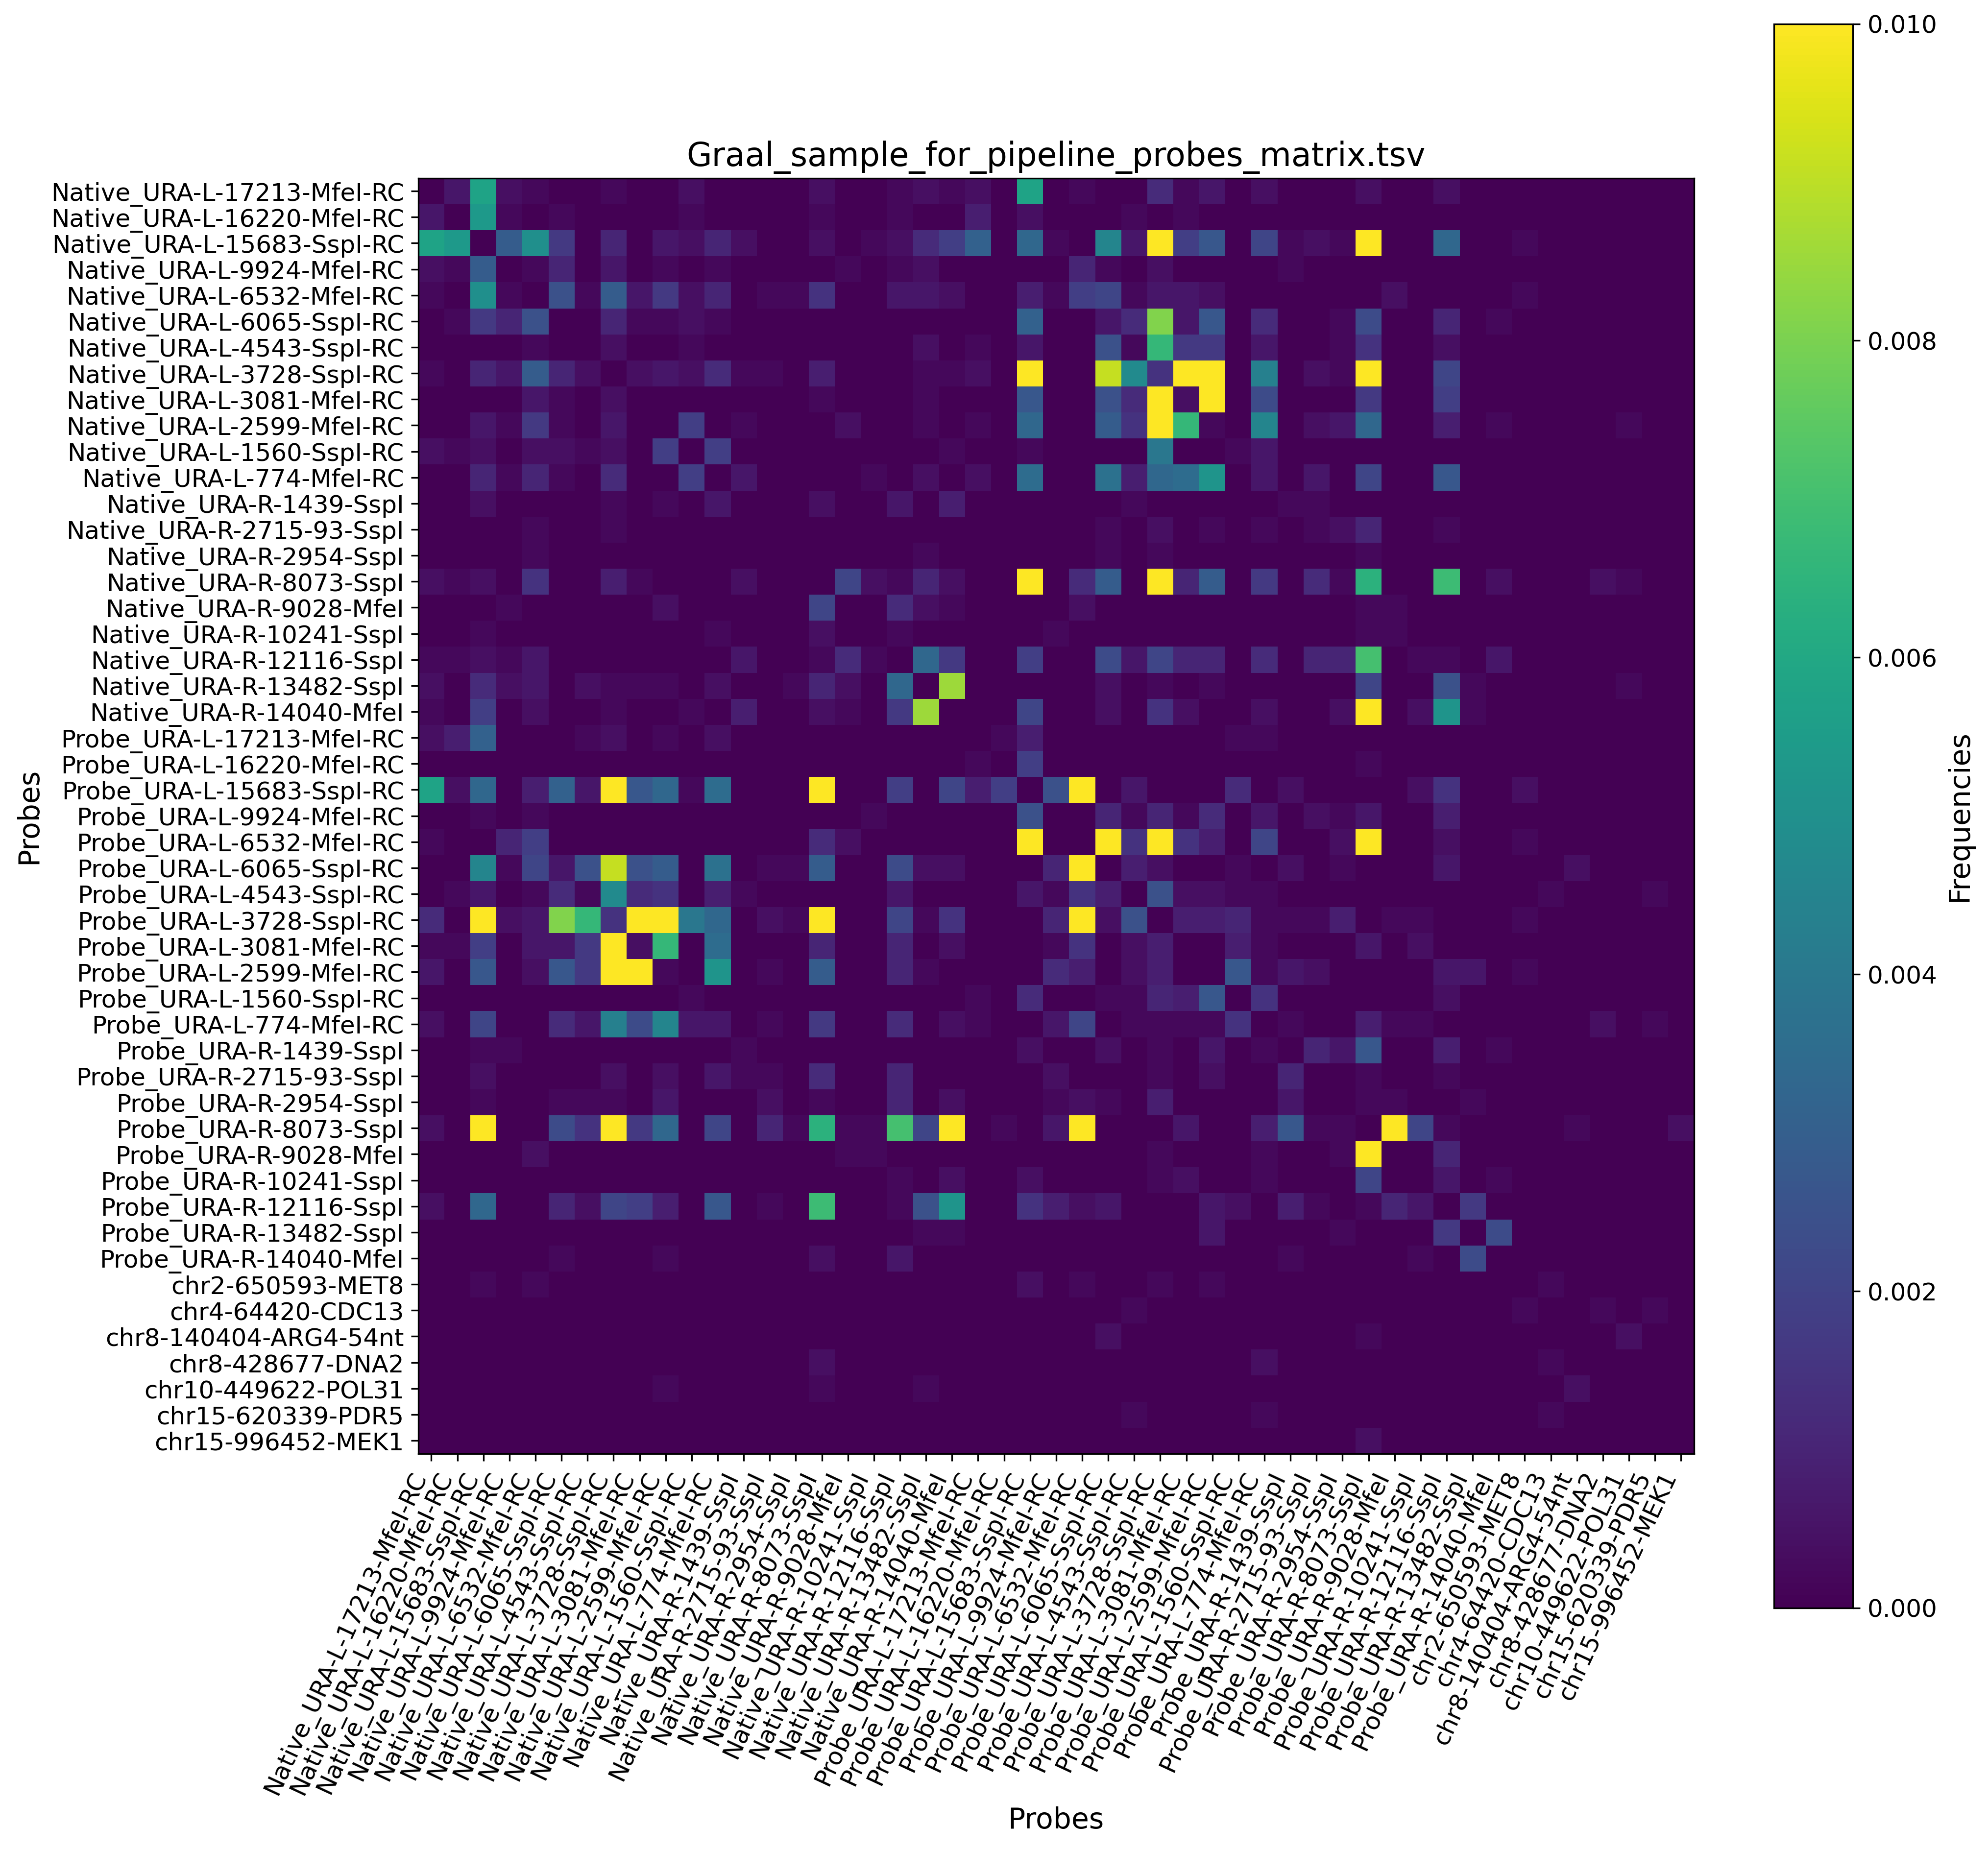

In [11]:
## Plot matrix of the probes-only generated above
ARGS = [
    "plotmatrix",
    "-m", probes_matrix_path,
    "-o", join(OUTPUTS_DIR, "probes_matrix_plot.png"),
    "-v", "0",
    "-V", "0.01",
]
cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}

from IPython.display import Image
Image(join(OUTPUTS_DIR, "probes_matrix_plot.png"))

### 5. 4C-like profiles at 0 kb

**What happens:**  
For each probe, contacts are grouped by genomic bins defined by fragment coordinates.  
A profile is built as contact counts or normalized frequencies per bin, optionally including additional probe groups.

**Outputs:**  
`*_0kb_profile_contacts.tsv` and, if `normalize=True`, `*_0kb_profile_frequencies.tsv`


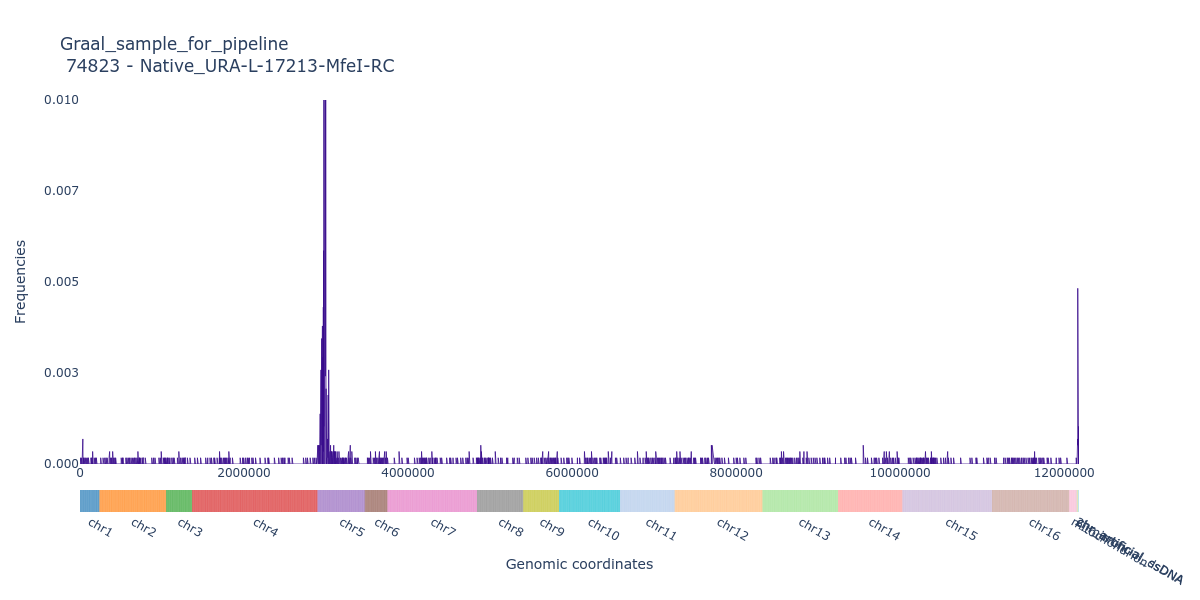

In [12]:
## Classical 4C profile no binning, normalized
# First make the profile

# Absolute contacts
profile_0kb_contacts_path = join(OUTPUTS_DIR, "Graal_sample_for_pipeline_0kb_profile_contacts.tsv")

ARGS = [
    "profile",
    "-c", capture_associated_path,
    "-C", join(INPUTS_DIR, coords),
    "-f", filtered_path,
    "-a", join(INPUTS_DIR, groups),
    "-o", profile_0kb_contacts_path,
    "-F"
]
cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}

# in normalized frequencies
profile_0kb_contacts_norm_path = join(OUTPUTS_DIR, "Graal_sample_for_pipeline_0kb_profile_frequencies.tsv")
ARGS = [
    "profile",
    "-c", capture_associated_path,
    "-C", join(INPUTS_DIR, coords),
    "-f", filtered_path,
    "-a", join(INPUTS_DIR, groups),
    "-o", profile_0kb_contacts_norm_path,
    "-N",
    "-F"
]
cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}

# Then plot the profile
## Plot4C of this profile

ARGS = [
    "plot4c",
    "-p", profile_0kb_contacts_norm_path,
    "-c", capture_associated_path,
    "-o", OUTPUTS_DIR,
    "-C", join(INPUTS_DIR, coords),
    "-e", "png",
    "-H", "600",
    "-W", "1200",
    "-r", "4",
    "-y", "0",
    "-Y", "0.01",
]
cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}


example_plot4c_probe_path = join(OUTPUTS_DIR, "plots/0kb/raw/Graal_sample_for_pipeline_74823_Native_URA-L-17213-MfeI-RC_frequencies_0kb_.png")
Image(example_plot4c_probe_path)

### 6. Rebin profiles

**What happens:**  
Converts the unbinned 0 kb profile to new resolutions.  
Fragments spanning multiple bins are proportionally split, and missing bins are zero-filled using a genome-wide template.

**Output:**  
`*_profile_<bin>.tsv`  
The suffix `<bin>` is generated by `get_bin_suffix()`.

INFO :: [Rebin] : Binned profile saved to ../test_data/outputs/Graal_sample_for_pipeline_1kb_profile_frequencies.tsv


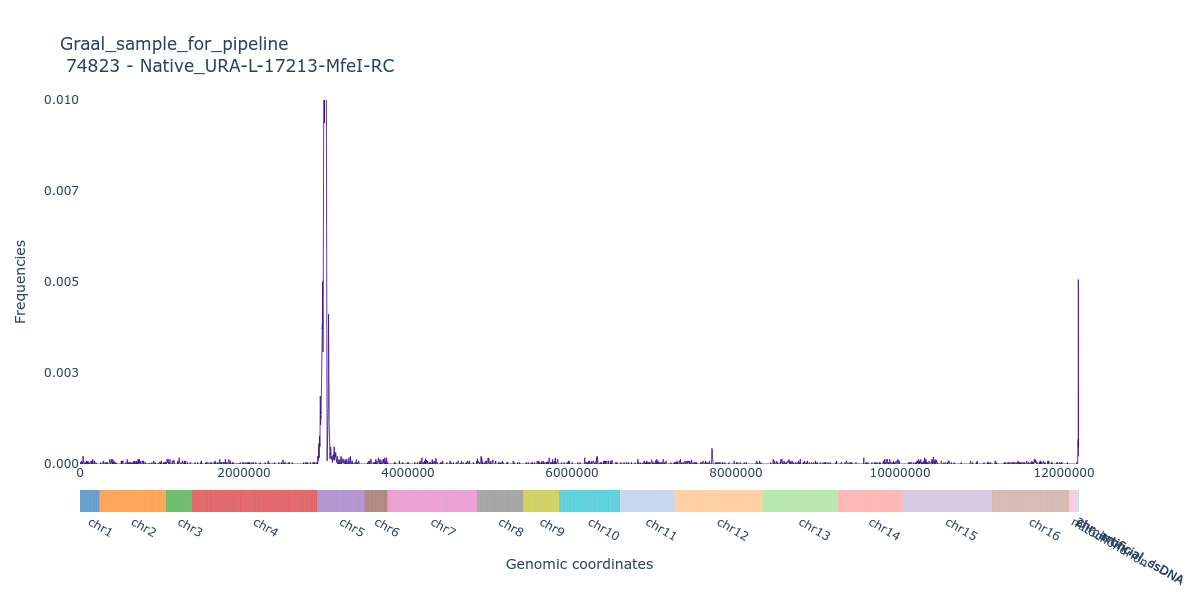

In [13]:
## Rebinning at 1 kb

ARGS = [
    "rebin",
    "-p", profile_0kb_contacts_norm_path,
    "-C", join(INPUTS_DIR, coords),
    "-b", "1000",
    "-F"
]
cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}

profile_1kb_freq_path = join(OUTPUTS_DIR, "Graal_sample_for_pipeline_1kb_profile_frequencies.tsv")
ARGS = [
    "plot4c",
    "-p", profile_1kb_freq_path,
    "-c", capture_associated_path,
    "-o", OUTPUTS_DIR,
    "-C", join(INPUTS_DIR, coords),
    "-e", "png",
    "-H", "600",
    "-W", "1200",
    "-r", "4",
    "-y", "0",
    "-Y", "0.01",
]

cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}

example_plot4c_probe_1kb_path = join(OUTPUTS_DIR, "plots/1kb/raw/Graal_sample_for_pipeline_74823_Native_URA-L-17213-MfeI-RC_frequencies_1kb_.png")
Image(example_plot4c_probe_1kb_path)

INFO :: [Rebin] : Binned profile saved to ../test_data/outputs/Graal_sample_for_pipeline_10kb_profile_frequencies.tsv


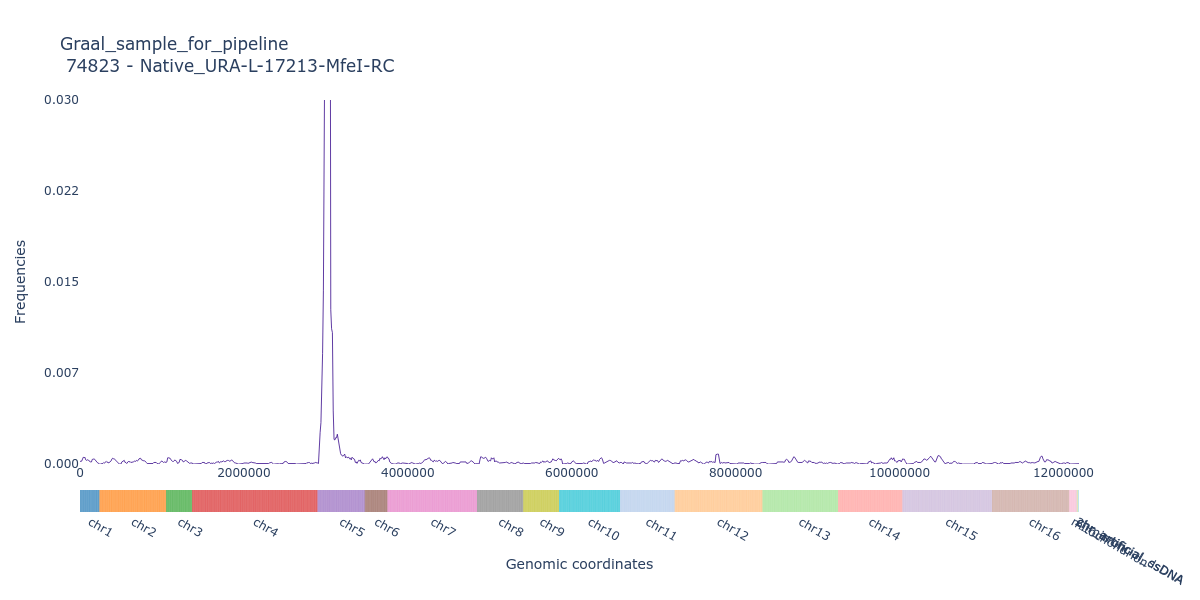

In [14]:
## Rebinning at 10 kb

ARGS = [
    "rebin",
    "-p", profile_0kb_contacts_norm_path,
    "-C", join(INPUTS_DIR, coords),
    "-b", "10000",
    "-F"
]
cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}

profile_10kb_freq_path = join(OUTPUTS_DIR, "Graal_sample_for_pipeline_10kb_profile_frequencies.tsv")
ARGS = [
    "plot4c",
    "-p", profile_10kb_freq_path,
    "-c", capture_associated_path,
    "-o", OUTPUTS_DIR,
    "-C", join(INPUTS_DIR, coords),
    "-e", "png",
    "-H", "600",
    "-W", "1200",
    "-r", "4",
    "-y", "0",
    "-Y", "0.03",
]

cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}

example_plot4c_probe_10kb_path = join(OUTPUTS_DIR, "plots/10kb/raw/Graal_sample_for_pipeline_74823_Native_URA-L-17213-MfeI-RC_frequencies_10kb_.png")
Image(example_plot4c_probe_10kb_path)



### 7. Per-probe statistics

**What happens:**  
Computes for each probe:
- total number of contacts  
- coverage relative to all Hi-C contacts  
- cis vs trans fractions (controlled by `cis_range`)  
- chromosome-wise normalized enrichment  
- inter-chromosome-only enrichment  

**Outputs:**  
`*_statistics.tsv`, `*_norm_chr_freq.tsv`, `*_norm_inter_chr_freq.tsv`


In [15]:
## Get statistics

ARGS = [
    "stats",
    "-m", join(INPUTS_DIR, graal),
    "-p", profile_0kb_contacts_path,
    "-c", capture_associated_path,
    "-C", join(INPUTS_DIR, coords),
    "-o", OUTPUTS_DIR,
    "-r", "50000",
    "-F"
]
cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}

stats_path = join(OUTPUTS_DIR, "Graal_sample_for_pipeline_statistics.tsv")
df_stats = pd.read_csv(stats_path, sep="\t")
df_stats.head()

INFO :: [Stats] : Generating statistics for contacts made by each probe.
INFO :: [Stats] : Statistics saved to ../test_data/outputs/Graal_sample_for_pipeline_statistics.tsv
INFO :: [Stats] : Normalized chr contacts saved to ../test_data/outputs/Graal_sample_for_pipeline_norm_chr_freq.tsv
INFO :: [Stats] : Normalized inter-only chr contacts saved to ../test_data/outputs/Graal_sample_for_pipeline_norm_inter_chr_freq.tsv


,probe,fragment,type,chr,contacts,coverage_over_hic_contacts,inter_chr,intra_chr,cis,trans,cis_with_artificial,trans_with_artificial,dsdna_norm_capture_efficiency
0,Native_URA-L-17213-MfeI-RC,74823,ss,chr5,5800.0,0.000218,0.188621,0.811379,0.731379,0.268621,0.746897,0.253103,0.126853
1,Native_URA-L-16220-MfeI-RC,74824,ss,chr5,1314.0,0.000049,0.152207,0.847793,0.763318,0.236682,0.795282,0.204718,0.028739
2,Native_URA-L-15683-SspI-RC,74825,ss,chr5,7892.0,0.000296,0.210973,0.789027,0.709579,0.290421,0.782311,0.217689,0.172607
3,Native_URA-L-9924-MfeI-RC,74826,ss,chr5,1154.0,0.000043,0.273830,0.726170,0.642114,0.357886,0.677643,0.322357,0.025239
4,Native_URA-L-6532-MfeI-RC,74827,ss,chr5,1681.0,0.000063,0.325996,0.674004,0.556217,0.443783,0.629387,0.370613,0.036765


In [16]:
norm_chr_freq_path = join(OUTPUTS_DIR, "Graal_sample_for_pipeline_norm_chr_freq.tsv")
df_norm_chr_freq = pd.read_csv(norm_chr_freq_path, sep="\t")
df_norm_chr_freq.head()

,probe,fragment,type,chr1,chr2,chr3,chr4,chr5,chr6,chr7,...,chr11,chr12,chr13,chr14,chr15,chr16,mitochondrion,2_micron,chr_artificial_dsDNA,chr_artificial_ssDNA
0,Native_URA-L-17213-MfeI-RC,74823,ss,0.347567,0.201718,0.277992,0.100547,16.119877,0.399843,0.148526,...,0.182996,0.168838,0.168787,0.160679,0.177807,0.158249,0.02332,6.649025,10.881402,11.893625
1,Native_URA-L-16220-MfeI-RC,74824,ss,0.153416,0.217166,0.390428,0.097985,16.479829,0.261468,0.161875,...,0.092692,0.139223,0.143274,0.135093,0.072820,0.111762,0.00000,6.987813,37.977637,8.935915
2,Native_URA-L-15683-SspI-RC,74825,ss,0.274592,0.238641,0.278594,0.112281,15.472287,0.299295,0.101069,...,0.187401,0.143172,0.112913,0.161197,0.136063,0.116301,0.00000,4.421129,25.478736,81.271588
3,Native_URA-L-9924-MfeI-RC,74826,ss,0.524062,0.321459,0.444560,0.164074,14.004046,0.595440,0.165887,...,0.361864,0.205151,0.217518,0.320465,0.193472,0.339353,0.00000,11.139325,40.699452,11.446721
4,Native_URA-L-6532-MfeI-RC,74827,ss,0.389747,0.373459,0.414184,0.238789,12.464443,0.587603,0.221435,...,0.320874,0.256064,0.291185,0.237597,0.297260,0.327606,0.00000,12.016877,76.835044,30.559393


In [17]:
norm_chr_freq_inter_only_path = join(OUTPUTS_DIR, "Graal_sample_for_pipeline_norm_inter_chr_freq.tsv")
df_norm_chr_freq_inter = pd.read_csv(norm_chr_freq_inter_only_path, sep="\t")
df_norm_chr_freq_inter.head()

,probe,fragment,type,chr1,chr2,chr3,chr4,chr5,chr6,chr7,...,chr11,chr12,chr13,chr14,chr15,chr16,mitochondrion,2_micron,chr_artificial_dsDNA,chr_artificial_ssDNA
0,Native_URA-L-17213-MfeI-RC,74823,ss,1.842679,1.069435,1.473816,0.533065,0.0,2.119825,0.787432,...,0.970181,0.895118,0.894848,0.851862,0.942671,0.838980,0.123637,35.250770,57.689333,63.055783
1,Native_URA-L-16220-MfeI-RC,74824,ss,1.007945,1.426783,2.565110,0.643762,0.0,1.717844,1.063519,...,0.608987,0.914693,0.941311,0.887559,0.478430,0.734275,0.000000,45.909932,249.513075,58.708959
2,Native_URA-L-15683-SspI-RC,74825,ss,1.301551,1.131143,1.320520,0.532204,0.0,1.418640,0.479063,...,0.888270,0.678627,0.535200,0.764064,0.644930,0.551258,0.000000,20.955885,120.767678,385.222448
3,Native_URA-L-9924-MfeI-RC,74826,ss,1.913820,1.173936,1.623487,0.599183,0.0,2.174485,0.605802,...,1.321492,0.749190,0.794355,1.170304,0.706542,1.239283,0.000000,40.679687,148.630276,41.802265
4,Native_URA-L-6532-MfeI-RC,74827,ss,1.195556,1.145592,1.270518,0.732490,0.0,1.802482,0.679255,...,0.984286,0.785481,0.893215,0.728835,0.911849,1.004939,0.000000,36.861989,235.692901,93.741495


### 8. Aggregate near centromeres and telomeres

**What happens:**  
Aggregates a **binned** profile around centromeres and telomeres using window sizes defined by `cen_agg_window_size` and `telo_agg_window_size`.  
Optionally removes intra-chromosomal contacts (`inter_chr_only=True`) and normalizes each probe column.  
Averages are computed per chromosome and across chromosomes.

**Outputs:**  
`<prefix>_mean.tsv`, `<prefix>_median.tsv`, `<prefix>_std.tsv`, and `<prefix>_<fragment>_per_chr.tsv`  
Saved under `aggregated/centromeres/` or `aggregated/telomeres/`.


In [18]:
## Aggregate on centromeres
ARGS = [
    "aggregate",
    "-p", profile_1kb_freq_path,
    "-c", capture_associated_path,
    "-C", join(INPUTS_DIR, coords),
    "-o", OUTPUTS_DIR,
    "-N",
    "--cen",
    "-w", "150000"
]
cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}
df_agg_cen = pd.read_table(join(OUTPUTS_DIR, "aggregated/centromeres/Graal_agg_on_cen_norm_mean.tsv"), sep="\t")
df_agg_cen.head()


INFO :: [Aggregate] : Contacts binned profile resolution: 1000 bp
INFO :: [Aggregate] : Normalizing contacts by column sums
INFO :: [Aggregate] : Aggregating contacts around centromeres
INFO :: [Aggregate] : Using window size: 150000 bp on each side
INFO :: [Aggregate] : Computing aggregated mean, median, and standard deviation per bin.
INFO :: [Aggregate] : Aggregation on centromere completed. Results saved in ../test_data/outputs/aggregated/centromeres


,Unnamed: 0,chr_bins,74823,74824,74825,74826,74827,74829,74830,74831,...,$avg_left_0-4kb_noly,$avg_left_0-4kb_ly,$avg_left_0-7kb_noly_pool3,$avg_left_0-7kb_noly_pool6,$avg_ly,$avg_left_0-7kb_ly_pool6,$avg_left_dsb-dist,$avg_right_0-3kb,$avg_right_0-8kb,$avg_right_all
0,0,0,0.000014,0.000048,0.000010,0.000031,0.000025,0.000000,0.000168,0.000074,...,0.000190,0.000152,0.000165,0.000132,0.000096,0.000123,0.000077,0.000257,0.000251,0.000278
1,1,1000,0.000029,0.000024,0.000023,0.000043,0.000110,0.000000,0.000277,0.000113,...,0.000242,0.000192,0.000205,0.000164,0.000117,0.000152,0.000038,0.000313,0.000295,0.000322
2,2,2000,0.000035,0.000044,0.000036,0.000092,0.000045,0.000036,0.000237,0.000114,...,0.000091,0.000089,0.000100,0.000095,0.000086,0.000093,0.000097,0.000235,0.000237,0.000280
3,3,3000,0.000037,0.000018,0.000032,0.000094,0.000074,0.000007,0.000167,0.000071,...,0.000076,0.000077,0.000088,0.000105,0.000080,0.000099,0.000161,0.000297,0.000357,0.000359
4,4,4000,0.000057,0.000073,0.000066,0.000000,0.000056,0.000138,0.000033,0.000083,...,0.000080,0.000100,0.000088,0.000072,0.000130,0.000087,0.000081,0.000368,0.000359,0.000371


In [19]:
df_agg_cen_per_chr = pd.read_table(join(OUTPUTS_DIR, "aggregated/centromeres/Graal_agg_on_cen_norm_avg_ly_per_chr.tsv"), sep="\t")
df_agg_cen_per_chr.head()

,chr_bins,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,chr11,chr12,chr13,chr14,chr15,chr16
0,0,0.000000,0.000043,0.000113,3.172186e-05,0.000407,0.000000,0.000124,0.000159,0.000234,0.000142,0.000063,0.000036,0.000055,0.000053,0.000000,0.000067
1,1000,0.000201,0.000051,0.000007,2.156507e-04,0.000271,0.000105,0.000049,0.000016,0.000174,0.000078,0.000195,0.000014,0.000031,0.000053,0.000391,0.000023
2,2000,0.000029,0.000129,0.000000,2.387235e-04,0.000320,0.000006,0.000016,0.000227,0.000063,0.000088,0.000016,0.000019,0.000004,0.000022,0.000032,0.000161
3,3000,0.000029,0.000061,0.000185,7.585663e-07,0.000247,0.000127,0.000048,0.000048,0.000038,0.000036,0.000298,0.000028,0.000016,0.000057,0.000009,0.000052
4,4000,0.000439,0.000251,0.000116,3.096330e-05,0.000303,0.000148,0.000033,0.000016,0.000073,0.000012,0.000080,0.000388,0.000032,0.000062,0.000057,0.000041


In [20]:
## Aggregate on telomeres
## Aggregate on centromeres
ARGS = [
    "aggregate",
    "-p", profile_1kb_freq_path,
    "-c", capture_associated_path,
    "-C", join(INPUTS_DIR, coords),
    "-o", OUTPUTS_DIR,
    "-N",
    "--tel",
    "-w", "15000"
]
cmd = "sshicstuff " + " ".join(ARGS)
!{cmd}
df_agg_tel = pd.read_table(join(OUTPUTS_DIR, "aggregated/telomeres/Graal_agg_on_telo_norm_mean.tsv"), sep="\t")
df_agg_tel.head()

INFO :: [Aggregate] : Contacts binned profile resolution: 1000 bp
INFO :: [Aggregate] : Normalizing contacts by column sums
INFO :: [Aggregate] : Aggregating contacts around telomeres
INFO :: [Aggregate] : Computing aggregated mean, median, and standard deviation per bin.
INFO :: [Aggregate] : Aggregation on telomeres completed. Results saved in ../test_data/outputs/aggregated/telomeres


,Unnamed: 0,chr_bins,74823,74824,74825,74826,74827,74829,74830,74831,...,$avg_left_0-4kb_noly,$avg_left_0-4kb_ly,$avg_left_0-7kb_noly_pool3,$avg_left_0-7kb_noly_pool6,$avg_ly,$avg_left_0-7kb_ly_pool6,$avg_left_dsb-dist,$avg_right_0-3kb,$avg_right_0-8kb,$avg_right_all
0,0,0,0.000270,0.000673,0.000321,0.000401,0.000473,0.000715,0.000364,0.001329,...,0.000171,0.000183,0.000162,0.000637,0.000201,0.000528,0.000550,0.000134,0.000210,0.000198
1,1,1000,0.000092,0.000107,0.000289,0.000358,0.000537,0.000795,0.000479,0.000667,...,0.000378,0.000295,0.000479,0.000668,0.000171,0.000544,0.000552,0.000264,0.000346,0.000316
2,2,2000,0.000093,0.000082,0.001144,0.000219,0.000647,0.001964,0.001832,0.001432,...,0.000348,0.000301,0.000336,0.001502,0.000230,0.001184,0.000312,0.000365,0.000350,0.000310
3,3,3000,0.000054,0.000035,0.000147,0.000083,0.000354,0.000736,0.000709,0.001278,...,0.000307,0.000320,0.000278,0.000252,0.000338,0.000274,0.000145,0.000250,0.000218,0.000202
4,4,4000,0.000071,0.000061,0.000157,0.000117,0.000414,0.000823,0.000667,0.001349,...,0.000317,0.000356,0.000291,0.000263,0.000416,0.000301,0.000153,0.000286,0.000245,0.000222


## Adjustable parameters

- `additional_groups`: Optional table to define probe groups for aggregation  
- `bin_sizes`: Target resolutions for rebinning (e.g., `[1000, 10000]`)  
- `excluded_chr`: Chromosomes to omit from aggregation  
- `cis_region_size`: Size of cis window in base pairs  
- `n_flanking_dsdna`: Number of dsDNA flanking fragments to remove  
- `inter_chr_only`: Exclude intra-chromosome signal during aggregation  
- `normalize`: Apply per-probe normalization for profiles and coverage  
- `cen_agg_window_size`, `telo_agg_window_size`: Window sizes in bp  
- `cen_aggregated_binning`, `telo_agg_binning`: Which binned profile to aggregate  
- `force`, `copy_inputs`: Overwrite control and reproducibility options


## Output folder structure

```bash
<run_dir>/
  inputs/
    sample.txt
    oligos.csv
    fragments.txt
    chr_coords.tsv

  <sample>_dsdna_only.txt
  <sample>_ssdna_only.txt
  <sample>_filtered.tsv
  <sample>_contacts_coverage.bedgraph
  <sample>_contacts_coverage_<bin>.bedgraph
  <sample>_0kb_profile_contacts.tsv
  <sample>_0kb_profile_frequencies.tsv
  <sample>_profile_<bin>.tsv
  <sample>_statistics.tsv
  <sample>_norm_chr_freq.tsv
  <sample>_norm_inter_chr_freq.tsv

  aggregated/
    centromeres/
      *_mean.tsv
      *_median.tsv
      *_std.tsv
    telomeres/
      *_mean.tsv
      *_median.tsv
      *_std.tsv
